In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, optimizers, callbacks
import seaborn as sns
import matplotlib.pyplot as plt
import os

2024-09-29 21:35:09.114061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 21:35:09.236730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 21:35:09.270327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 21:35:09.412361: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-29 21:35:12.024116: W tensorflow/compiler/tf2

In [2]:
# Flag for using Google Colab
colab_on = True
base_path = ""

In [39]:
# if we are using google colab we need to mount the drive
# and set the base path to the root of the drive
if colab_on:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = '/content/drive/My Drive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Loading the data
X = np.load(os.path.join(base_path, 'x_digits.npy'))
y = np.load(os.path.join(base_path, 'y_digits.npy'))

# Converting data to respectively float32 and int64
X = X.astype(np.float32)
y = y.astype(np.int64)

In [4]:
X.shape, y.shape

((35631, 129, 71), (35631,))

In [41]:
# We are combining X and y into singular tensorflow dataset
# because the data is ordered (all examples of 0, then all examples of 1, etc.), we need to shuffle it, so our splits contain all classes
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(buffer_size=len(X))

In [42]:
# Calculating size of each data split
dataset_size = len(X)
train_size = int(0.64 * dataset_size)
val_size = int(0.16 * dataset_size)
test_size = dataset_size - train_size - val_size

In [43]:
# Splitting the data in datasets
train_dataset = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

In [44]:
batch_size = 64

In [45]:
# we are creating datasets for the training, validation and test set
# we want to shuffle the training set each epoch in order to prevent the model from learning the order of the data
train_dataset = train_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [46]:
# we define our fully connected neural network
# we use batch normalization to stabilize training
# we also use it before the first layer to normalize the input data
# becaues the spectogram is 2D, we flatten it to a 1D tensor
# we use ReLU as activation function
# we use kaiming (He) initialization for the weights in linear layers, because we use ReLU
fcn = models.Sequential([
        layers.Input(shape=(129, 71)),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(10, activation='softmax')
    ])

In [47]:
# Hyperparameters for our FCN
fcn_hyperparams = {
    'n_epochs': 30,
    'lr': 0.001,
    'scheduler_patience': 4,
    'scheduler_factor': 0.5,
    'early_stop_patience': 6,
    'weight_decay': 0.1
}

In [48]:
optimizer = optimizers.AdamW(learning_rate=fcn_hyperparams['lr'], weight_decay=fcn_hyperparams['weight_decay'])
fcn.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [49]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=fcn_hyperparams['early_stop_patience'],
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    factor=fcn_hyperparams['scheduler_factor'],
    patience=fcn_hyperparams['scheduler_patience'],
)

In [50]:
# we use the AdamW optimizer and reduce the learning rate on plateau after 4 epochs without improvement
history = fcn.fit(
    train_dataset,
    epochs=fcn_hyperparams['n_epochs'],
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.2780 - loss: 2.1218 - val_accuracy: 0.5937 - val_loss: 1.2037 - learning_rate: 0.0010
Epoch 2/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5346 - loss: 1.3238 - val_accuracy: 0.7025 - val_loss: 0.8818 - learning_rate: 0.0010
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6243 - loss: 1.0909 - val_accuracy: 0.7635 - val_loss: 0.7327 - learning_rate: 0.0010
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6710 - loss: 0.9533 - val_accuracy: 0.7719 - val_loss: 0.7011 - learning_rate: 0.0010
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6986 - loss: 0.8751 - val_accuracy: 0.8184 - val_loss: 0.5768 - learning_rate: 0.0010
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7263 - loss: 0.8042 - val_accuracy: 0.8381 - val_loss: 0.5212 - learning_rate: 0.0010
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7421 - loss: 0.7667 

In [51]:
def evaluate_model(model, dataset_name='test'):

    # empty confusion matrix
    confusion_matrix = tf.zeros((10, 10), dtype=tf.int32)

    if dataset_name == 'test':
        dataset = test_dataset
    elif dataset_name == 'train':
        dataset = train_dataset
    elif dataset_name == 'val':
        dataset = val_dataset

    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for X_batch, y_batch in dataset:
        # getting model predictions for te batch
        y_pred = model(X_batch, training=False)

        # updating the accuracy metric
        # this method accumulates the value of the metric
        # so it is suitable for batched data
        accuracy.update_state(y_batch, y_pred)

        # getting the predicted classes by picking the class with the highest probability
        y_pred_classes = tf.argmax(y_pred, axis=-1)
        # we stack the true labels and the predicted labels
        true_pred = tf.stack([y_batch, y_pred_classes], axis=-1)

        # we update the confusion matrix
        # by incrementing the value by 1 in the cell corresponding to the true and predicted label
        confusion_matrix = tf.tensor_scatter_nd_add(
            confusion_matrix,
            true_pred,
            tf.ones(tf.shape(y_batch)[0], dtype=tf.int32)
        )

    acc = accuracy.result().numpy()
    print(f"{dataset_name.capitalize()} accuracy: {acc:.4f}")

    # ploting the confusion matrix
    # we use seaborn to plot the confusion matrix
    # we display the number of cases in each cell of the matrix
    sns.heatmap(confusion_matrix.numpy(), annot=True, fmt='g', cmap='Blues')
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

Test accuracy: 0.9247


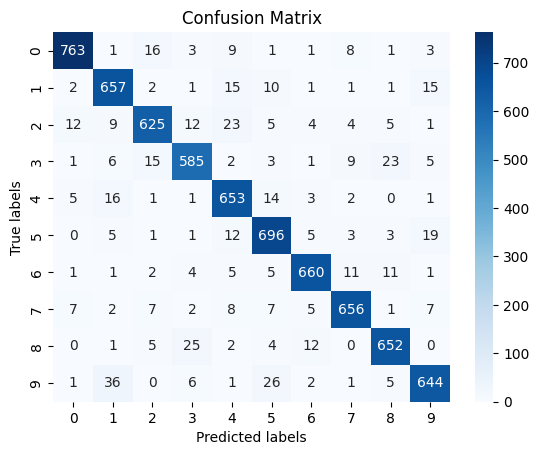

In [52]:
evaluate_model(fcn)

From the confusion matrix we can clearly see that one of the caveats of this model is that it confuses 9 with 1 or 5.
Other than that the we don't catch any drastic anomalies, rest of the errors are more or less evenly distributed.
We can investigate the spectograms of the numbers that are close to each other to see if they are indeed similar.

In [53]:
def plot_spectograms(n = 5, digit = 1):

    _, axs = plt.subplots(1, n, figsize=(15, 5))

    # displaying few examples of the spectograms of the digit
    for i in range(n):
        # we are finding indices of spectograms of the digit
        idx = np.random.choice(np.where(y == digit)[0])
        axs[i].imshow(X[idx])
        axs[i].axis('off')
        axs[i].set_title(f"Digit {digit}")

    plt.show()

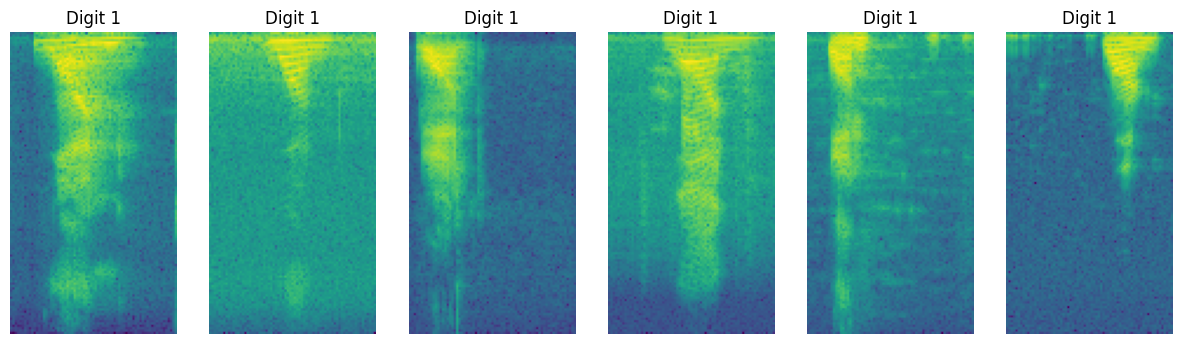

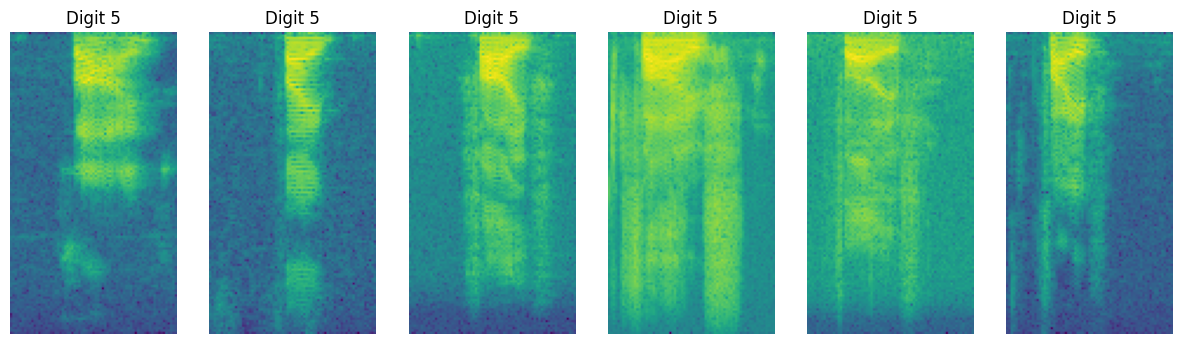

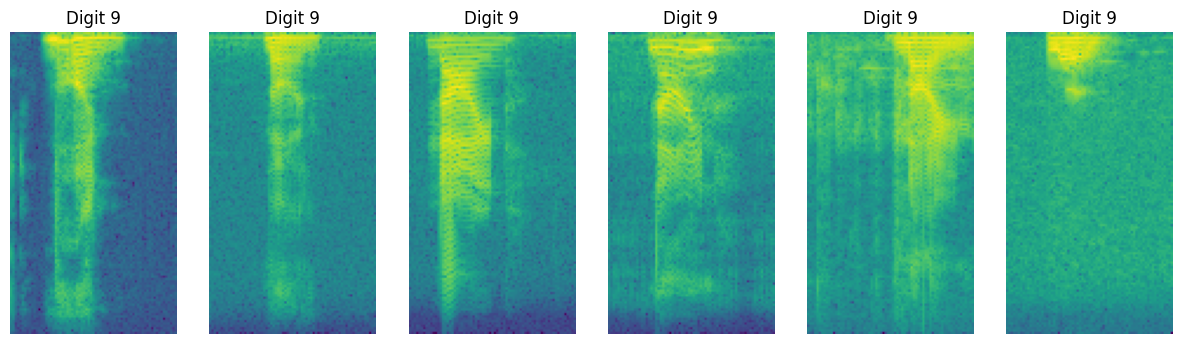

In [54]:
# Plot spectrograms
plot_spectograms(n=6, digit=1)
plot_spectograms(n=6, digit=5)
plot_spectograms(n=6, digit=9)

To be fair without domain knowledge, it is hard to tell if the 1s, 5s and 9s are similar or not. Of course it looks like there are some similar patterns, but the spectograms are too chaotic at least for us

In [55]:
# we are using 3 convolution blocks with increasing number of features maps
# because we are using padding='same' the shape of the output of convolution will be the same as input
# we are using batch normalization and dropout to stabilize training
# we decided to use dropout only before the last linear layer as it was working nicely experimentally
# also in literature we saw that it is popular to only put dropout in fully connected part in conv nets
conv_net = models.Sequential([
        layers.Input(shape=(129, 71, 1)),
        layers.Conv2D(16, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

In [56]:
# hyperparams are similar to the ones used for the FCN, but we train for much shorter time
# because this network is much 'stronger' and learns faster
cnn_hyperparams = {
    'n_epochs': 15,
    'lr': 0.001,
    'scheduler_patience': 3,
    'scheduler_factor': 0.5,
    'early_stop_patience': 5,
    'weight_decay': 0.1
}

In [57]:
optimizer = optimizers.AdamW(learning_rate=cnn_hyperparams['lr'], weight_decay=cnn_hyperparams['weight_decay'])
conv_net.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [58]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=cnn_hyperparams['early_stop_patience'],
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    factor=cnn_hyperparams['scheduler_factor'],
    patience=cnn_hyperparams['scheduler_patience'],
)

In [59]:
history = conv_net.fit(
    train_dataset,
    epochs=cnn_hyperparams['n_epochs'],
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4220 - loss: 2.5922 - val_accuracy: 0.7467 - val_loss: 0.8542 - learning_rate: 0.0010
Epoch 2/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7716 - loss: 0.8317 - val_accuracy: 0.8835 - val_loss: 0.3742 - learning_rate: 0.0010
Epoch 3/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8544 - loss: 0.5093 - val_accuracy: 0.9030 - val_loss: 0.3254 - learning_rate: 0.0010
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8741 - loss: 0.4046 - val_accuracy: 0.9337 - val_loss: 0.2061 - learning_rate: 0.0010
Epoch 5/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8984 - loss: 0.3240 - val_accuracy: 0.9346 - val_loss: 0.2008 - learning_rate: 0.0010
Epoch 6/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9207 - loss: 0.2522 - val_accuracy: 0.9586 - val_loss: 0.1353 - learning_rate: 0.0010
Epoch 7/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9265 - loss: 0.2251 

Test accuracy: 0.9759


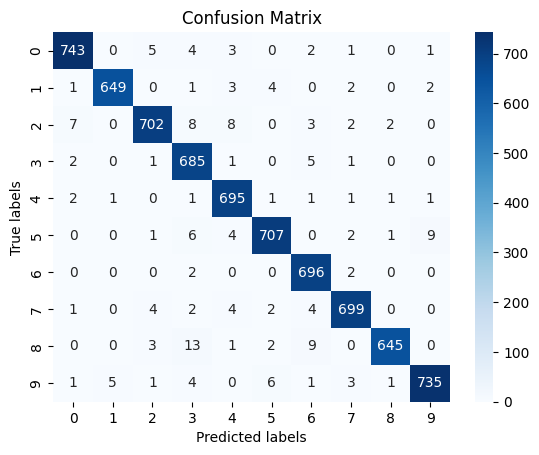

In [60]:
evaluate_model(conv_net)

To sum up convolution network is much more powerful than fully connected network. However, it is more prone to overfitting as well as it is much more demanding in terms of computational power.